# Randomized Benchmarking

A **randomized benchmarking (RB)** experiment consists of the generation of random Clifford circuits on the given qubits such that the unitary computed by the circuits is the identity. After running the circuits, the number of shots resulting in an error (i.e. an output different than the ground state) are counted, and from this data one can infer error estimates for the quantum device, by calculating the Error Per Clifford. 
See [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html) for an explanation on the RB method, which is based on Ref. [1, 2].

In [2]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

# 1. RB experiment

To run the RB experiment we need need to provide the following RB parameters, in order to generate the RB circuits and run them on a backend:


- `qubits`: The number of qubits or list of physical qubits for the experiment.

- `lengths`: A list of RB sequences lengths. 

- `num_samples`: Number of samples to generate for each sequence length.

- `seed`: Seed or generator object for random number generation. If `None` then `default_rng` will be used.

- `full_sampling`: If `True` all Cliffords are independently sampled for all lengths. If `False` for sample of lengths longer sequences are constructed by appending additional Clifford samples to shorter sequences. The deafult is `False`.

The output of the RB Experiment includes:

- `EPC`: The estimated Error Per Clifford.

- `EPC_err`: The statistical error bounds of the EPC.

- `alpha`: The depolarizing parameter. The fitting function is $a \cdot \alpha^m + b$, where $m$ is the Clifford length.

- `EPG`: The Error Per Gate calculated from the EPC, only for 1-qubit or 2-qubit quantum gates (see Ref. [3]).

## Running 1-qubit RB experiment

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 54852203-5882-43ea-a964-74306414742f
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4799282405991423 ± 0.00776521714187951
- alpha: 0.9957814610860524 ± 0.00021305744369979
- b: 0.5052777259675665 ± 0.0074893922576876985
- analysis_type: RBAnalysis
- reduced_chisq: 0.02732331862428102
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.002109269456973817
- EPC_err: 0.00010698002123247915
- EPG: {0: {'rz': 0.0, 'sx': 0.00042704910486588966, 'x': 0.00042704910486588966}}
- success: True


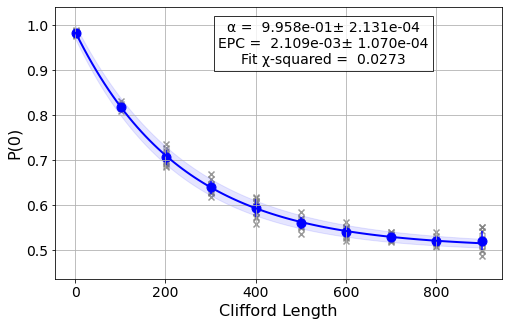

In [3]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]
# Run an RB experiment on qubit 0
exp1 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB experiment

Running a 1-qubit RB experiment and a 2-qubit RB experiment, in order to calculate the gate error (EPG) of  the `cx` gate:

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 003e8991-eb24-47b3-803e-a00471c8d0c0
Status: DONE
Circuits: 70
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6901269887451205 ± 0.020135950232959096
- alpha: 0.9632283184618221 ± 0.0023394448859173156
- b: 0.2676986425134453 ± 0.008347769486744582
- analysis_type: RBAnalysis
- reduced_chisq: 0.018242281958427545
- dof: 4
- xrange: [1.0, 181.0]
- EPC: 0.02757876115363342
- EPC_err: 0.0018215656981928011
- EPG: {(1, 4): {'cx': 0.01239730838137366}}
- success: True
Backend's reported EPG of the cx gate: 0.012438847900902494
Experiment computed EPG of the cx gate: 0.01239730838137366


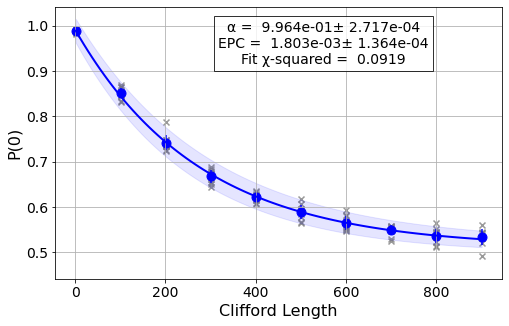

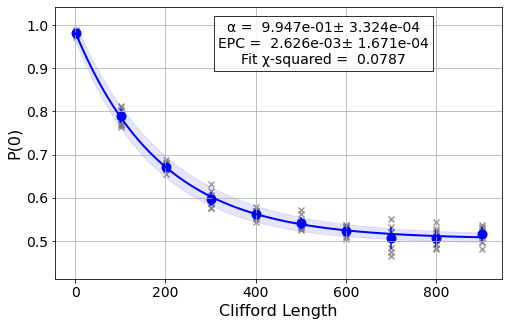

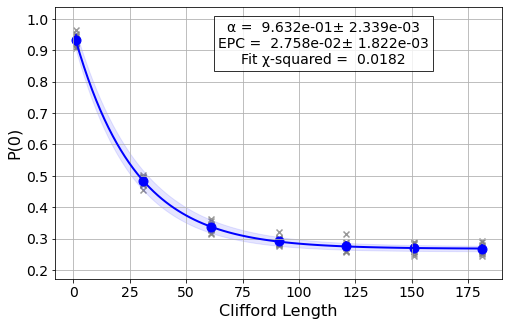

In [4]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
epg_data = {}
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in qubits:
    exp = rb.StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend)
    epg_data[qubit] = expdata.analysis_result(0)['EPG'][qubit]
    
# Run an RB experiment on qubits 1, 4
exp2 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_data)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
expected_epg = rb.RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_result(0)['EPG'][qubits]['cx']
print("Backend's reported EPG of the cx gate:", expected_epg)
print("Experiment computed EPG of the cx gate:", exp2_epg)

## Displaying the RB circuits

Generating an example RB circuit:

In [5]:
# Run an RB experiment on qubit 0
exp = rb.StandardRB(qubits=[0], lengths=[10], num_samples=1, seed=seed)
c = exp.circuits()[0]

We transpile the circuit into the backend's basis gate set:

In [6]:
from qiskit import transpile
basis_gates = backend.configuration().basis_gates
print(transpile(c, basis_gates=basis_gates))

global phase: π/2
         ░ ┌──────────┐┌────┐┌───────┐ ░ ┌────┐┌─────────┐ ░ ┌──────────┐┌────┐»
   q_0: ─░─┤ RZ(3π/2) ├┤ √X ├┤ RZ(π) ├─░─┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├┤ √X ├»
         ░ └──────────┘└────┘└───────┘ ░ └────┘└─────────┘ ░ └──────────┘└────┘»
meas: 1/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌───────┐ ░ ┌────┐┌────┐┌───────┐ ░  ░ ┌─────────┐┌────┐ ░ ┌────┐»
«   q_0: ┤ RZ(π) ├─░─┤ √X ├┤ √X ├┤ RZ(π) ├─░──░─┤ RZ(π/2) ├┤ √X ├─░─┤ √X ├»
«        └───────┘ ░ └────┘└────┘└───────┘ ░  ░ └─────────┘└────┘ ░ └────┘»
«meas: 1/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌─────────┐ ░ ┌──────────┐ ░ ┌────┐┌──────────┐ ░ ┌────┐┌──────────┐»
«   q_0: ┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├»
«        └─────────┘ ░ └──────────┘ ░ └

# 2. Interleaved RB experiment

Interleaved RB experiment is used to estimate the gate error of the interleaved gate (see Ref. [4]).

In addition to the usual RB parameters, we also need to provide:

- `interleaved_element`: the element to interleave, given either as a group element or as an instruction/circuit

The output of the RB Experiment includes the following:

- `EPC`: The estimated error of the interleaved gate.

- `EPC_err`: The statistical error bounds of the interleaved gate error.

- `alpha` and `alpha_c`: The depolarizing parameters of the original and interleaved RB sequences respectively.

- `EPC_systematic_err`: The systematic error of the interleaved gate error (see Ref. [4]).

- `EPC_systematic_bounds`: The systematic error bounds of the interleaved gate error (see Ref. [4]).


## Running 1-qubit interleaved RB experiment

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: bd9c55af-5394-45f2-8871-0f37bf13e291
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4742714890941567 ± 0.006841291651414359
- alpha: 0.9956458318473806 ± 0.0002041711648223685
- alpha_c: 0.9990306326594092 ± 0.0002871378846395361
- b: 0.5099324832647216 ± 0.006510888951732237
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.07293276218104913
- dof: 16
- xrange: [1.0, 901.0]
- EPC: 0.00048468367029541604
- EPC_err: 0.00014356894231976804
- EPC_systematic_err: 0.003869484482323937
- EPC_systematic_bounds: [0, 0.004354168152619353]
- success: True


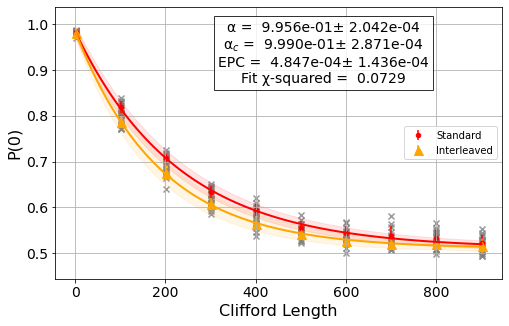

In [7]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

# Run an Interleaved RB experiment on qubit 0
# The interleaved gate is the x gate
int_exp1 = rb.InterleavedRB(circuits.XGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

## Running 2-qubit interleaved RB experiment

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: 1ac71542-7fc6-4cf8-bdd3-173c4bd410d4
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6869789687113003 ± 0.015548203844509308
- alpha: 0.9650297294469435 ± 0.002959908703064314
- alpha_c: 0.9849094551092367 ± 0.004876102375956638
- b: 0.25926092291379593 ± 0.005550821488042492
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.055083725398781744
- dof: 10
- xrange: [1.0, 181.0]
- EPC: 0.011317908668072502
- EPC_err: 0.003657076781967479
- EPC_systematic_err: 0.04113749716151219
- EPC_systematic_bounds: [0, 0.05245540582958469]
- success: True


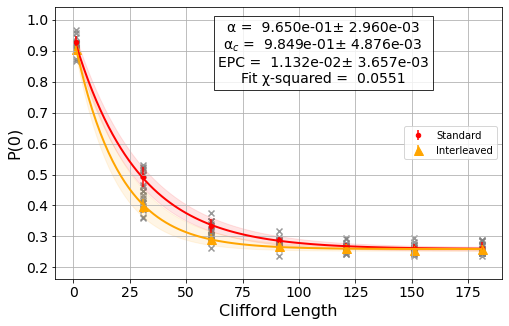

In [8]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [4,6]

# Run an Interleaved RB experiment on qubits 4, 6
# The interleaved gate is the cx gate
int_exp2 = rb.InterleavedRB(circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

# 3. Simultaneous RB experiment

We use `ParallelExperiment` to run the RB experiment simultaneously on different qubits (see Ref. [5])

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 9af9adcf-b751-40ab-a99d-4c27332acde4
Status: DONE
Component Experiments: 5
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['StandardRB', 'StandardRB', 'StandardRB', 'StandardRB', 'StandardRB']
- experiment_ids: ['df6b04fa-efb6-4b55-a40a-5720703d53e0', '312bd857-84b8-4ec3-9907-09ea7b390af5', '4defc2f7-c077-4c48-864a-c2f695c8660c', 'c658cbdd-b6b8-4480-a9ef-a766c45bcef2', '92db8d1c-a999-4166-bafc-27cb23f31c9e']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]
- success: True


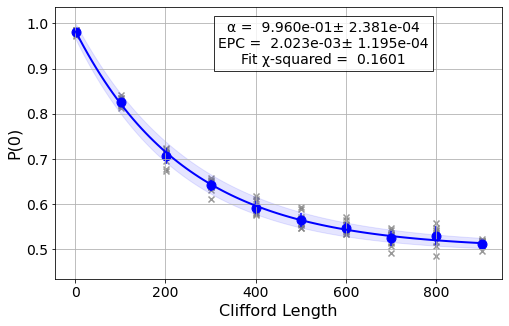

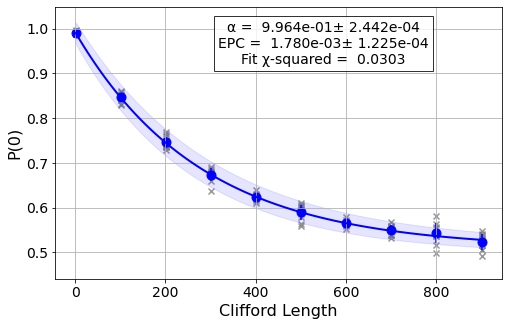

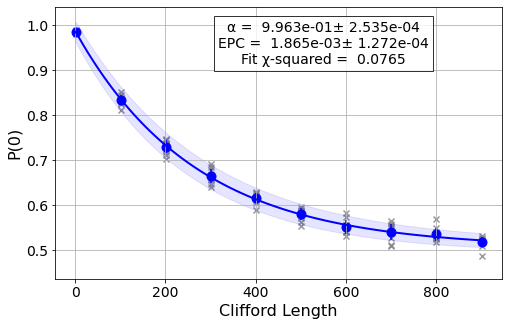

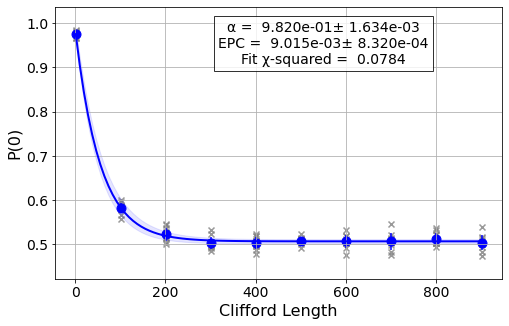

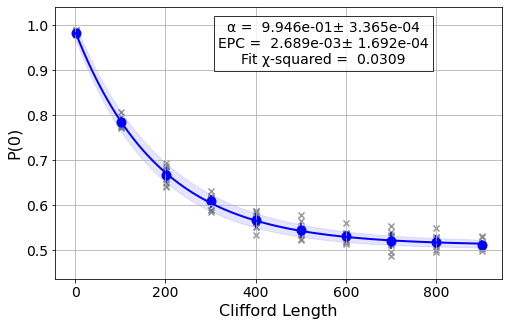

In [9]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = range(5)

# Run a parallel 1-qubit RB experiment on qubits 0, 1, 2, 3, 4
exps = [rb.StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in qubits]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

## Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [10]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')

---------------------------------------------------
Experiment: StandardRB
Experiment ID: df6b04fa-efb6-4b55-a40a-5720703d53e0
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4833163865231586 ± 0.008899754151950063
- alpha: 0.9959540862446398 ± 0.00023810333970453743
- b: 0.5007099832957054 ± 0.008333997196873619
- analysis_type: RBAnalysis
- reduced_chisq: 0.16008992621286625
- dof: 7
- xrange: [1.0, 901.0]
- EPC: 0.0020229568776801155
- EPC_err: 0.00011953529936421751
- EPG: {0: {'rz': 0.0, 'sx': 0.00040957399773618034, 'x': 0.00040957399773618034}}
- success: True 

---------------------------------------------------
Experiment: StandardRB
Experiment ID: 312bd857-84b8-4ec3-9907-09ea7b390af5
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4838772403669906 ± 0.012104289620688904
- alpha: 0.9964402294051187 ± 0.0002441696232132525

## References

[1] Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*, https://arxiv.org/pdf/1009.3639

[2] Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*, https://arxiv.org/pdf/1109.6887

[3] David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

[4] Easwar Magesan, Jay M. Gambetta, B. R. Johnson, Colm A. Ryan, Jerry M. Chow, Seth T. Merkel, Marcus P. da Silva, George A. Keefe, Mary B. Rothwell, Thomas A. Ohki, Mark B. Ketchen, M. Steffen, 
*Efficient measurement of quantum gate error by interleaved randomized benchmarking*,
https://arxiv.org/pdf/1203.4550

[5] Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow, Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen, *Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308

